# NYC Building-level Mold Issues prediction

### Author: Bartosz Bonczak

In [45]:
import pandas as pd
import numpy as np
import geopandas as gpd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

import pickle


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns
sns.set_theme(style="whitegrid")

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [54]:
def plot_conf_matrix(y, predicted, labels, title='Confucion Matrix'):
    # Creating  a confusion matrix,which compares the y_test and y_pred
    cm = confusion_matrix(y, predicted)
    # Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
    cm_df = pd.DataFrame(cm,
                        index = labels, 
                        columns = labels)

    #Plotting the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True, fmt='', 
    cbar=False,
    cmap=ListedColormap(['white']),
    linewidths=1, linecolor='black')
    plt.title(title)
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    
    return cm_df

# Modeling Data Preparation

### Load Required Data

In [7]:
# Mold Data
mold_main = pd.read_csv("../output/mold_issues_combined.csv")
mold_main.BBL = mold_main.BBL.astype(int).astype(str).str.zfill(10)
print(mold_main.shape)
mold_main.head()

(61180, 18)


,BBL,violation_count,Latitude,Longitude,first_InspectionDate,last_InspectionDate,max_Class,ViolationStatus,avg_days_to_close,with_violation,comp_count,first_ComplaintDate,last_ComplaintnDate,avg_days_to_close_comp,with_complaint,first_mold_issue,last_mold_issue,mold_issue
0,0000000000,5.0,40.822745,-73.900336,2022-08-03,2022-10-12,B,Open,147.50,1.0,16.0,2010-09-09,2022-12-28,22.500000,1.0,NaN,NaN,1
1,1000077501,2.0,40.703630,-74.010586,2021-04-28,2021-04-28,B,Close,121.00,1.0,1.0,2017-10-01,2017-10-01,5.000000,1.0,NaN,NaN,1
2,1000157501,2.0,40.705949,-74.016288,2022-11-07,2022-11-07,B,Close,164.00,1.0,6.0,2020-03-24,2022-12-16,18.166667,1.0,NaN,NaN,1
3,1000160100,8.0,40.711244,-74.015925,2010-02-22,2019-10-12,C,Close,903.75,1.0,35.0,2010-02-15,2022-06-10,40.857143,1.0,NaN,NaN,1
4,1000167519,1.0,40.716525,-74.014815,2018-10-18,2018-10-18,A,Close,142.00,1.0,2.0,2018-09-25,2020-10-23,17.000000,1.0,NaN,NaN,1


In [8]:
# NYC PLUTO
pluto = pd.read_csv("../output/pluto_processed.csv")
pluto.bbl = pluto.bbl.astype(int).astype(str).str.zfill(10)
print(pluto.shape)
pluto.head()

(858619, 36)


,bbl,latitude,longitude,yearbuilt,yearalter1,yearalter2,bldgclass,landuse,bldgarea,resarea,...,bldg_value,main_bldg_class,proxcode_attached,proxcode_detached,proxcode_not_available,proxcode_semi_attached,bsmtcode_bsmt_above,bsmtcode_bsmt_below,bsmtcode_no_basement,bsmtcode_not_available
0,3018090016,40.687196,-73.946599,1899-01-01,NaN,NaN,A4,1.0,1210.0,1210.0,...,44100.0,A,0,0,0,1,0,1,0,0
1,3061830033,40.614595,-73.992299,1930-01-01,NaN,NaN,B1,1.0,1551.0,1551.0,...,42780.0,B,0,0,0,1,1,0,0,0
2,3062060022,40.612501,-73.991842,1930-01-01,NaN,NaN,B1,1.0,2352.0,2352.0,...,74340.0,B,0,0,0,1,0,1,0,0
3,3018520037,40.681827,-73.941303,1899-01-01,NaN,NaN,C0,2.0,2124.0,1411.0,...,72180.0,C,1,0,0,0,1,0,0,0
4,3058930008,40.632047,-74.021282,1907-01-01,NaN,NaN,S2,4.0,3132.0,2098.0,...,57780.0,S,0,0,1,0,0,1,0,0


In [9]:
# Load Floodplain - PLUTO cross reference
flood = pd.read_csv("../data/big_data/pluto_flood_nta.csv")
flood.bbl = flood.bbl.astype(int).astype(str).str.zfill(10)
print(flood.shape)
flood.head()

(856350, 10)


,bbl,latitude,longitude,geometry,in_fz,boro_code,boro_name,county_fip,ntacode,ntaname
0,3018090016,40.687196,-73.946599,POINT (-73.9465987 40.6871961),0,3.0,Brooklyn,47,BK75,Bedford
1,3018520037,40.681827,-73.941303,POINT (-73.941303 40.6818274),0,3.0,Brooklyn,47,BK75,Bedford
2,3018140073,40.686098,-73.947108,POINT (-73.947108 40.6860984),0,3.0,Brooklyn,47,BK75,Bedford
3,3018190050,40.685573,-73.944631,POINT (-73.9446313 40.685573),0,3.0,Brooklyn,47,BK75,Bedford
4,3018190003,40.685376,-73.946914,POINT (-73.9469138 40.6853764),0,3.0,Brooklyn,47,BK75,Bedford


### Merge data on BBL identifier

In [10]:
pluto = pluto.merge(flood[['bbl', 'in_fz', 'ntacode','ntaname']], how='left')

pluto_mold = pluto.merge(
    mold_main.rename(columns={'BBL':'bbl'}), 
    on='bbl', how='left'
)

In [25]:
for c in ['yearbuilt','yearalter1','yearalter2', 
          'first_InspectionDate','last_InspectionDate', 
          'first_ComplaintDate', 'last_ComplaintnDate']:
    pluto_mold[c] = pd.to_datetime(pluto_mold[c], errors='coerce').dt.date

# Data Exploration

In [29]:
bldg_class_dict = {
    'A':'ONE FAMILY DWELLINGS',
    'B':'TWO FAMILY DWELLINGS',
    'C':'WALK UP APARTMENTS',
    'D':'ELEVATOR APARTMENTS',
    'E':'WAREHOUSES',
    'F':'FACTORIES AND INDUSTRIAL BUILDINGS',
    'G':'GARAGES',
    'H':'HOTELS',
    'I':'HOSPITALS AND HEALTH FACILITIES',
    'J':'THEATRES',
    'K':'STORE BUILDINGS',
    'L':'LOFTS',
    'M':'RELIGIOUS FACILITIES',
    'N':'ASYLUMS AND HOMES',
    'O':'OFFICE BUILDINGS',
    'P':'INDOOR PUBLIC ASSEMBLY & CULT. FACILITIES',
    'Q':'OUTDOOR RECREATIONAL FACILITIES',
    'R':'CONDOMINIUMS',
    'S':'PRIMARILY RES. - MIXED USE',
    'T':'TRANSPORTATION FACILITIES',
    'U':'UTILITY BUREAU PROPERTIES',
    'V':'VACANT LAND',
    'W':'EDUCATIONAL FACILITIES',
    'Y':'GOVERNMENT/CITY DEPARTMENTS',
    'Z':'MISC. BUILDING CLASSIFICATIONS',
    'n':'OTHER'

}

In [26]:
print(f'pluto data size: {pluto_mold.shape}')
print(f'number of mold violations: {pluto_mold.with_violation.sum()}; {round(pluto_mold.with_violation.sum()/len(pluto_mold)*100, 2)}% of all')
print(f'number of mold complaints: {pluto_mold.with_complaint.sum()}; {round(pluto_mold.with_complaint.sum()/len(pluto_mold)*100, 2)}% of all')
print(f'number of all mold issues: {pluto_mold.mold_issue.sum()}; {round(pluto_mold.mold_issue.sum()/len(pluto_mold)*100, 2)}% of all')

pluto data size: (858619, 56)
number of mold violations: 33849.0; 3.94% of all
number of mold complaints: 55760.0; 6.49% of all
number of all mold issues: 60856.0; 7.09% of all


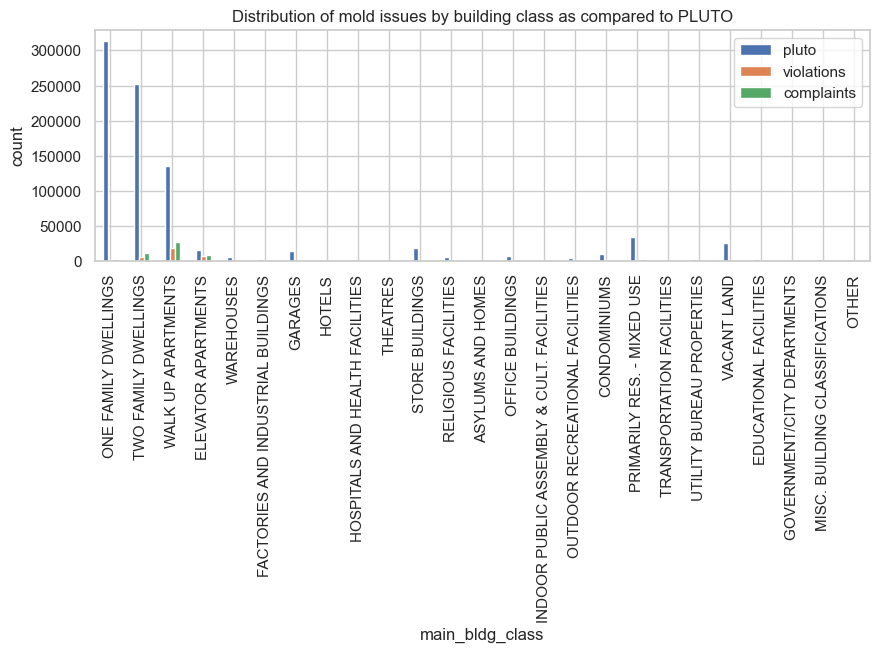

In [33]:
plot_df = pd.concat(
    [
        pluto_mold.groupby('main_bldg_class')['bbl'].count(),
        (pluto_mold[pluto_mold.with_violation==1].groupby('main_bldg_class')['bbl'].count()),
        (pluto_mold[pluto_mold.with_complaint==1].groupby('main_bldg_class')['bbl'].count()),
    ], 
    axis=1
)

plot_df.columns = ['pluto', 'violations', 'complaints']

plot_df.sort_index(ascending=True).plot.bar(width=0.5, figsize=(10,3), log=False)
plt.title('Distribution of mold issues by building class as compared to PLUTO')
plt.ylabel('count')
plt.xticks(range(len(plot_df)), [bldg_class_dict[c] for c in plot_df.sort_index(ascending=True).index])
plt.show()

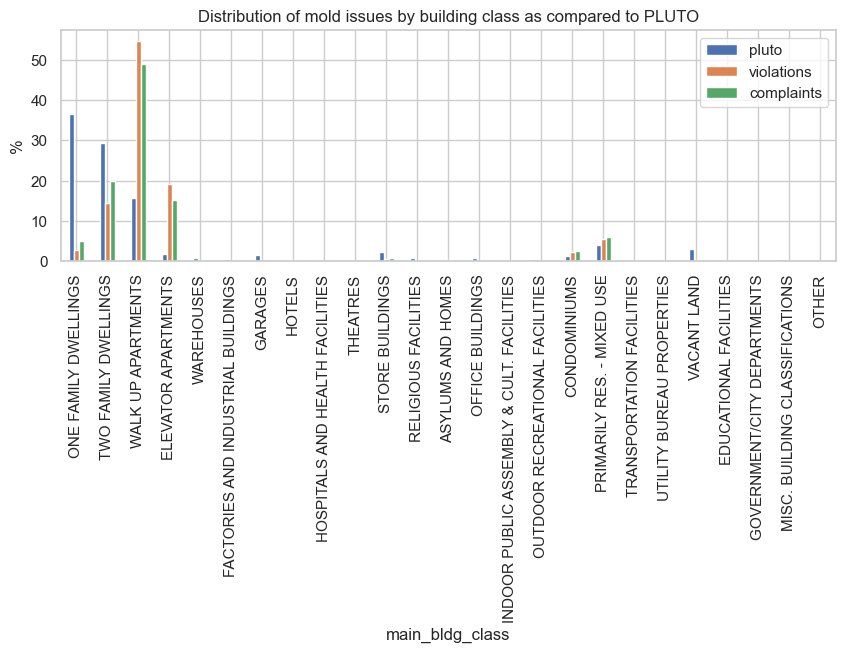

In [36]:
plot_df = pd.concat(
    [
        pluto_mold.groupby('main_bldg_class')['bbl'].count()/len(pluto_mold),
        (pluto_mold[pluto_mold.with_violation==1].groupby('main_bldg_class')['bbl'].count()/len(pluto_mold[pluto_mold.with_violation==1])),
        (pluto_mold[pluto_mold.with_complaint==1].groupby('main_bldg_class')['bbl'].count()/len(pluto_mold[pluto_mold.with_complaint==1])),
    ], 
    axis=1
)

plot_df = plot_df*100
plot_df.columns = ['pluto', 'violations', 'complaints']

plot_df.sort_index(ascending=True).plot.bar(width=0.5, figsize=(10,3), log=False)
plt.title('Distribution of mold issues by building class as compared to PLUTO')
plt.ylabel('%')
plt.xticks(range(len(plot_df)), [bldg_class_dict[c] for c in plot_df.sort_index(ascending=True).index])
plt.show()

# Prepare Data to Model

In [37]:
modeling_df = pluto_mold.copy()

modeling_columns = [
    'bbl',
    'mold_issue','with_violation','with_complaint',
    'latitude', 'longitude', 'age', 'age_since_alt',
    'bldgarea', 'numbldgs', 'numfloors', 'unitstotal', 
    'pct_res', 'avg_unit_size', 'bldg_shape_ratio',
    'bldg_value', 'main_bldg_class', 'proxcode_attached',
    'proxcode_detached', 'proxcode_semi_attached',
    'bsmtcode_bsmt_above', 'bsmtcode_bsmt_below', 'bsmtcode_no_basement',
    'in_fz',
]

modeling_df = pluto_mold.copy()
print(len(modeling_df))
modeling_df = modeling_df[modeling_columns]
modeling_df = modeling_df[modeling_df.main_bldg_class.isin(['A', 'B', 'C', 'D', 'R', 'S'])]
modeling_df.age_since_alt = modeling_df.age_since_alt.fillna(modeling_df.age)
modeling_df[['mold_issue','with_violation',	'with_complaint']] = modeling_df[['mold_issue','with_violation',	'with_complaint']].fillna(0)
print(len(modeling_df))

modeling_df = modeling_df.join(pd.get_dummies(modeling_df[['main_bldg_class']]))
modeling_df.drop(columns=['main_bldg_class'], inplace=True)

modeling_df = modeling_df.replace([-np.inf, np.inf], np.nan).dropna()
print(len(modeling_df))

modeling_df.drop_duplicates(inplace=True)
print(len(modeling_df))

modeling_df.head()

858619
758935
749383
749383


,bbl,mold_issue,with_violation,with_complaint,latitude,longitude,age,age_since_alt,bldgarea,numbldgs,...,bsmtcode_bsmt_above,bsmtcode_bsmt_below,bsmtcode_no_basement,in_fz,main_bldg_class_A,main_bldg_class_B,main_bldg_class_C,main_bldg_class_D,main_bldg_class_R,main_bldg_class_S
0,3018090016,0.0,0.0,0.0,40.687196,-73.946599,124.0,124.0,1210.0,1.0,...,0,1,0,0.0,1,0,0,0,0,0
1,3061830033,0.0,0.0,0.0,40.614595,-73.992299,93.0,93.0,1551.0,1.0,...,1,0,0,0.0,0,1,0,0,0,0
2,3062060022,0.0,0.0,0.0,40.612501,-73.991842,93.0,93.0,2352.0,2.0,...,0,1,0,0.0,0,1,0,0,0,0
3,3018520037,0.0,0.0,0.0,40.681827,-73.941303,124.0,124.0,2124.0,1.0,...,1,0,0,0.0,0,0,1,0,0,0
4,3058930008,0.0,0.0,0.0,40.632047,-74.021282,116.0,116.0,3132.0,1.0,...,0,1,0,0.0,0,0,0,0,0,1


<AxesSubplot:>

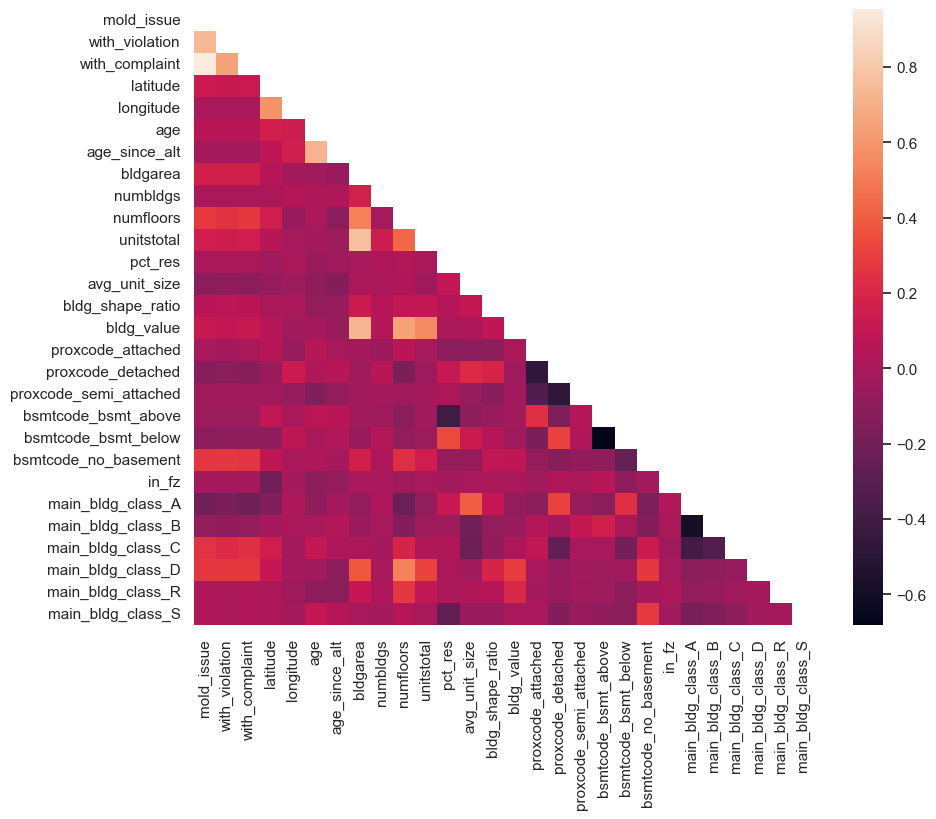

In [38]:
plt.figure(figsize=(10,8))

cor = modeling_df.corr()
mask = np.zeros_like(cor, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(cor,mask=mask,annot=False)

# Perform Random Forest modeling

1. Exhaustive Grid Search hyper-parameter tuning on 3-fold Cross-validation
2. Re-model using re-balancing based on best estimator from the previous step
3. Adjust model sensitivity of the best estimator

### Define variables

In [43]:
# Let's take "mold_issue" as the target variable. 
y=modeling_df.loc[:,"mold_issue"]

# Get the feature space.
X=modeling_df.loc[:,"latitude":]

# Perform 30% test/train split
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=999)


### 1. Train RF model with GridSearchCV

In [ ]:
# set hyper parameters range
param_grid = {
    'max_features':['sqrt', 'log2', 0.25, .5],
    'max_depth':[1, 10, 100, None],
    'min_samples_leaf':[50, 10, 1],
    'max_leaf_nodes':[1, 10, 100, None],
    'n_estimators':[10,50,100,200],
    }

# Perform GridSearchCV
rf = RandomForestClassifier(n_jobs=-1)
gs = GridSearchCV(rf,param_grid=param_grid,scoring='roc_auc', verbose=4, cv=3)
rs = gs.fit(X_train,y_train)
pred=rs.predict_proba(X_test)[:,1]
print(rs.best_estimator_)
print(roc_auc_score(np.array(y_test),pred))

It took 8 hours to run this hyperparameter tuning and below is the output. The model was saved into the pickle file.

```
RandomForestClassifier(max_depth=100, max_features=0.25, min_samples_leaf=50,
                       n_estimators=200, n_jobs=-1)
0.8809723945501307
```

In [41]:
# file name, I'm using *.pickle as a file extension
filename = "../output/mold_risk_RF_05-02-2023.pickle"
# # save model
# pickle.dump(rs, open(filename, "wb"))

# to load the model
rs = pickle.load(open(filename, "rb"))

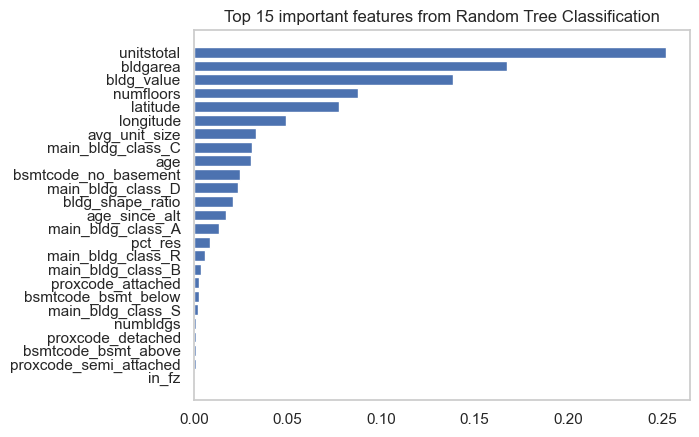

In [44]:
# Feature Importance (thx Matthias)
feat_importances = pd.DataFrame(rs.best_estimator_.feature_importances_, index=X.columns,
    columns=['importance']).sort_values('importance',ascending=True)
plt.barh(feat_importances.index,feat_importances.importance)
plt.title("Top 15 important features from Random Tree Classification")
plt.grid()
plt.show()

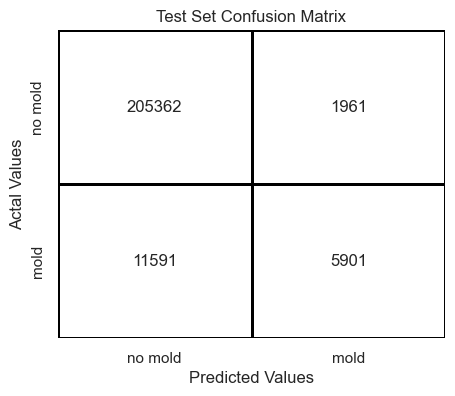

,no mold,mold
no mold,205362,1961
mold,11591,5901


In [55]:
plot_conf_matrix(y_test, rs.predict(X_test), ['no mold','mold'], title='Test Set Confusion Matrix')

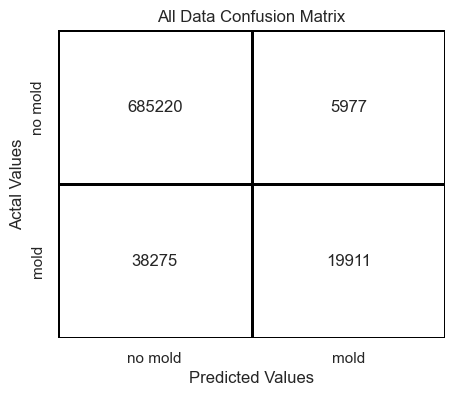

,no mold,mold
no mold,685220,5977
mold,38275,19911


In [57]:
plot_conf_matrix(y, rs.predict(X), ['no mold','mold'], title='All Data Confusion Matrix')

### 2. Re-balance data and re-run the model

In [ ]:
param_grid_new = {
    'criterion':['gini', 'entropy', 'log_loss'],
    'class_weight':['balanced', 'balanced_subsample', {0:1, 1:2}, {0:1, 1:11}],
    'max_samples':[0.1, 0.25, 0.5],
    }

rf_new = RandomForestClassifier(max_depth=100, max_features=0.25, min_samples_leaf=50,
                       n_estimators=200, n_jobs=-1)
gs_new = GridSearchCV(rf_new,param_grid=param_grid_new,scoring='roc_auc', verbose=4, cv=5)
rs_new = gs_new.fit(X_train,y_train)
pred_new=rs_new.predict_proba(X_test)[:,1]
print(rs_new.best_estimator_)
print(roc_auc_score(np.array(y_test),pred_new))

It tookThis time the model run for 3 hours... The model was saved into the pickle file.

```
RandomForestClassifier(class_weight={0: 1, 1: 11}, criterion='entropy',
                       max_depth=100, max_features=0.25, max_samples=0.5,
                       min_samples_leaf=50, n_estimators=200, n_jobs=-1)
0.881565868591409
```

In [53]:
# Save best model to pickle file fur further use
# file name, I'm using *.pickle as a file extension
filename = "../output/mold_risk_RF_balanced_05-02-2023.pickle"

# # save model
# pickle.dump(rs_new, open(filename, "wb"))

# to load the model
rs_new = pickle.load(open(filename, "rb"))

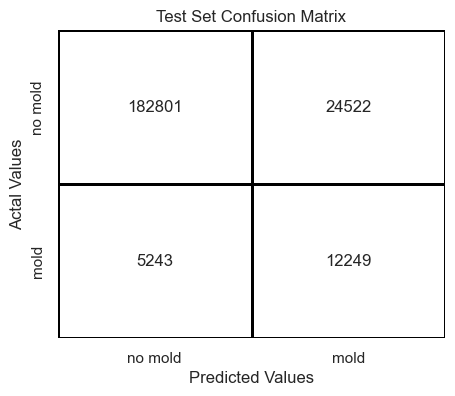

,no mold,mold
no mold,182801,24522
mold,5243,12249


In [58]:
plot_conf_matrix(y_test, rs_new.predict(X_test), ['no mold','mold'], title='Test Set Confusion Matrix')

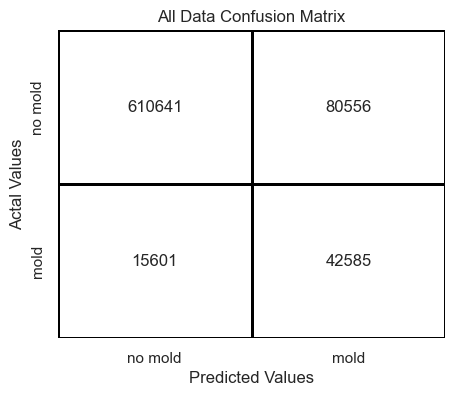

,no mold,mold
no mold,610641,80556
mold,15601,42585


In [59]:
plot_conf_matrix(y, rs_new.predict(X), ['no mold','mold'], title='All Data Confusion Matrix')

### 3. Adjust model sensitivity

Optimized Pr threshold = 0.4 with AUC=0.7978


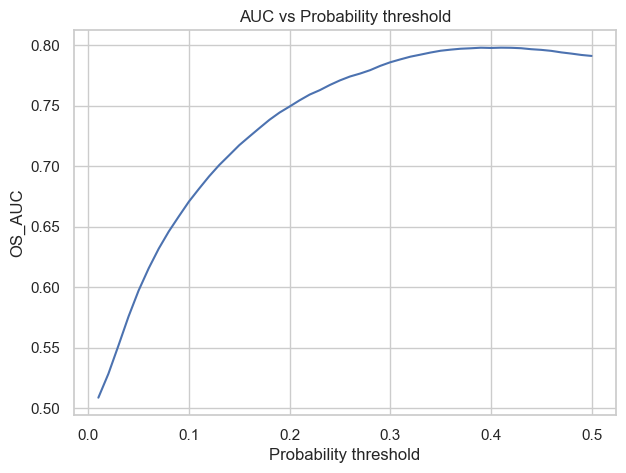

In [64]:
AUC_OS=[]

for p in np.arange(0.01, 0.51, 0.01):
    print(p)
    adj_pred = [0 if x<p else 1 for x in rs_new.predict_proba(X_test)[:,1]]

    # print(roc_auc_score(np.array(y_test),adj_pred))
    AUC_OS.append(roc_auc_score(np.array(y_test),adj_pred))
    clear_output(wait=True)

print(f"Optimized Pr threshold = {AUC_OS.index(max(AUC_OS))*0.01} with AUC={round(max(AUC_OS),4)}")

plt.figure(figsize=(7,5))
plt.plot(np.arange(0.01, 0.51, 0.01),AUC_OS)
plt.xlabel("Probability threshold")
plt.ylabel("OS_AUC")
plt.title("AUC vs Probability threshold")
plt.show()

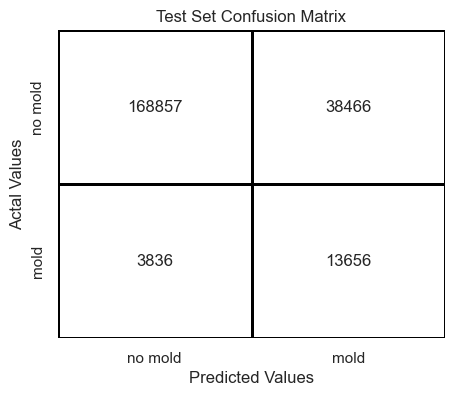

,no mold,mold
no mold,168857,38466
mold,3836,13656


In [65]:
plot_conf_matrix(y_test, [0 if x<0.4 else 1 for x in rs_new.predict_proba(X_test)[:,1]], 
                 ['no mold','mold'], title='Test Set Confusion Matrix')

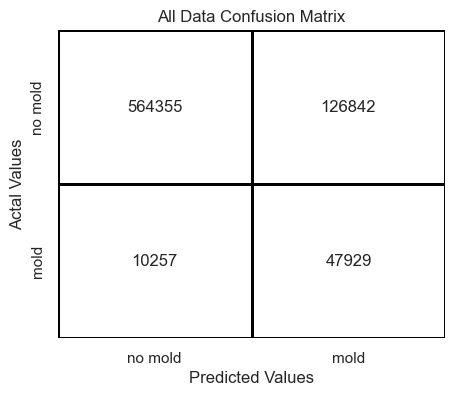

,no mold,mold
no mold,564355,126842
mold,10257,47929


In [66]:
plot_conf_matrix(y, [0 if x<0.4 else 1 for x in rs_new.predict_proba(X)[:,1]], 
                 ['no mold','mold'], title='All Data Confusion Matrix')

### Save Results

In [67]:
res_df = modeling_df[['bbl']]
res_df['mold'] = [0 if x<0.4 else 1 for x in rs_new.predict_proba(X)[:,1]]
res_df['mold_prob'] = rs_new.predict_proba(X)[:,1]
res_df.to_csv('../output/bbl_mold_risk_RF_balanced_pr04_05032023.csv', index=False)
res_df.head()


,bbl,mold,mold_prob
0,3018090016,0,0.192126
1,3061830033,0,0.082196
2,3062060022,0,0.119711
3,3018520037,1,0.537469
4,3058930008,0,0.254062
